In [118]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

In [119]:
categories = ['Abyssinian', 'Bombay', 'Birman','samoyed']


In [120]:
def load_images(data_dir, categories):
    images = []
    labels = []
    for img_file in os.listdir(data_dir):
        if img_file.lower().endswith('.jpg'):
            category = '_'.join(img_file.split('_')[:-1])
            if category in categories:
                img_path = os.path.join(data_dir, img_file)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (32, 32))  
                    images.append(img)
                    labels.append(category)
    return np.array(images), np.array(labels)


In [121]:
X, y = load_images("images", categories)

In [122]:
X = X.reshape(X.shape[0], -1)

In [123]:
X = X / 255.0  


In [124]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print(len(y_encoded))


799


In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [126]:
#Extract features
pca = PCA(n_components=300)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

Logistic Regression Model

In [127]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_pca, y_train)

LogisticRegression(max_iter=1000)

In [128]:
y_pred = model.predict(X_test_pca)

In [129]:
accuracy = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 73.75%


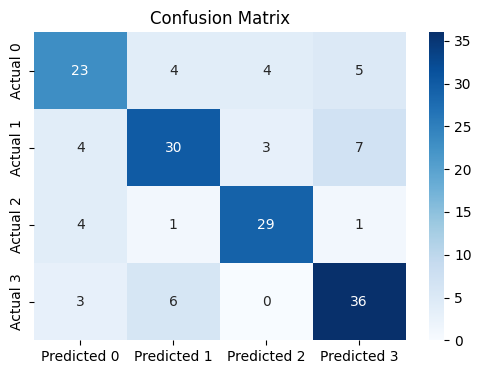

In [130]:
from sklearn.metrics import  confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
conf_matrix_df = pd.DataFrame(cm, index=[f"Actual {i}" for i in range(len(cm))], columns=[f"Predicted {i}" for i in range(len(cm))])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_df, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


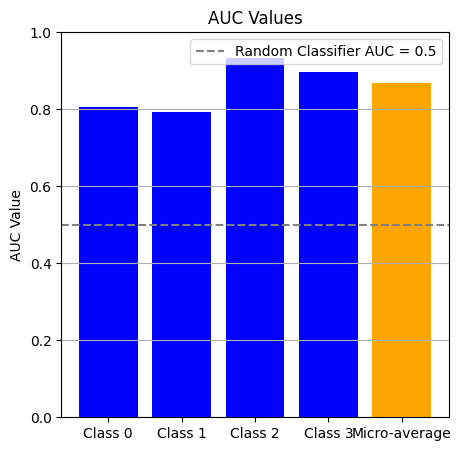

In [131]:

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


n_classes = len(set(y_test))  
y_test_bin = label_binarize(y_test, classes=range(n_classes))  
y_scores = model.predict_proba(X_test_pca) 


roc_auc = []

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
    roc_auc.append(auc(fpr, tpr))

fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_scores.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)


plt.figure(figsize=(5, 5))
class_names = [f'Class {i}' for i in range(n_classes)] 
class_names.append('Micro-average')  

auc_values = roc_auc + [roc_auc_micro]  

plt.bar(class_names, auc_values, color=['blue'] * n_classes + ['orange'])
plt.ylim(0, 1)  
plt.ylabel('AUC Value')
plt.title('AUC Values')
plt.grid(axis='y')
plt.axhline(y=0.5, color='gray', linestyle='--', label='Random Classifier AUC = 0.5')
plt.legend()
plt.show()


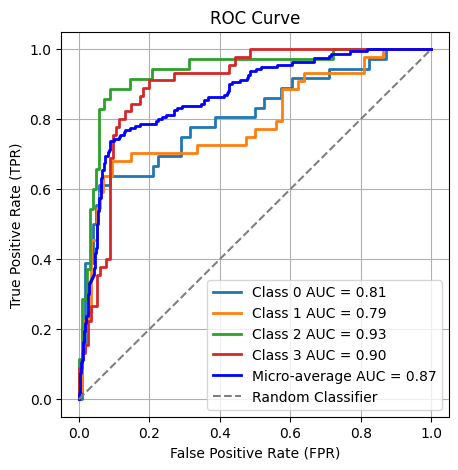

In [132]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


plt.figure(figsize=(5, 5))


for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], linewidth=2, label=f"Class {i} AUC = {roc_auc[i]:.2f}")


plt.plot(fpr["micro"], tpr["micro"], color="blue", linewidth=2, label=f"Micro-average AUC = {roc_auc['micro']:.2f}")


plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random Classifier")

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [133]:
from sklearn.metrics import log_loss
loss_value = log_loss(y_test_bin, y_scores)
print(f"Log Loss: {loss_value:.4f}")

Log Loss: 1.2674


In [134]:
for label in np.unique(y_train):
    print(f"Number of training examples for class {label}: {sum(np.array(y_train) == label)}")

for label in np.unique(y_test):
    print(f"Number of testing examples for class {label}: {sum(np.array(y_test) == label)}")

Number of training examples for class 0: 163
Number of training examples for class 1: 156
Number of training examples for class 2: 165
Number of training examples for class 3: 155
Number of testing examples for class 0: 36
Number of testing examples for class 1: 44
Number of testing examples for class 2: 35
Number of testing examples for class 3: 45


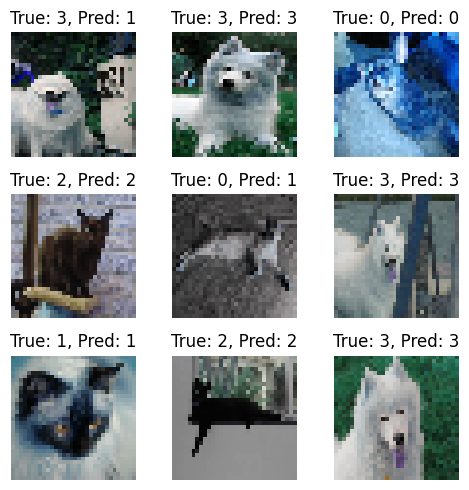

In [135]:
plt.figure(figsize=(5, 5))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[i].reshape(32, 32,3), cmap='gray')
    plt.title(f"True: {y_test[i]}, Pred: {y_pred[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

KNN Model


In [136]:
from sklearn.neighbors import KNeighborsClassifier
k = 3
knn = KNeighborsClassifier(n_neighbors=k, metric = 'minkowski', p = 2)

knn.fit(X_train_pca, y_train)

KNeighborsClassifier(n_neighbors=3)

In [137]:
Y_pred = knn.predict(X_test_pca)

In [138]:
# Predict on test set
accuracy = accuracy_score(y_test, Y_pred)

print(f"Test Accuracy: {accuracy * 100:.2f}%")



Test Accuracy: 58.75%


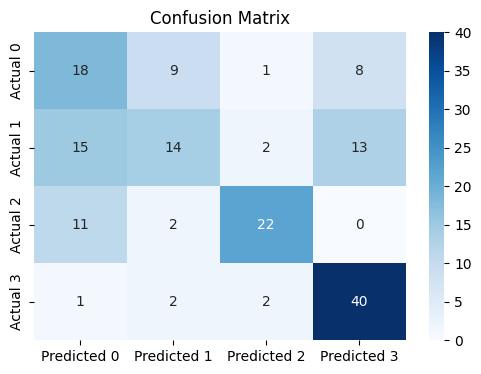

In [139]:

cm = confusion_matrix(y_test, Y_pred)

# Display the confusion matrix
conf_matrix_df = pd.DataFrame(cm, index=[f"Actual {i}" for i in range(len(cm))], columns=[f"Predicted {i}" for i in range(len(cm))])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_df, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


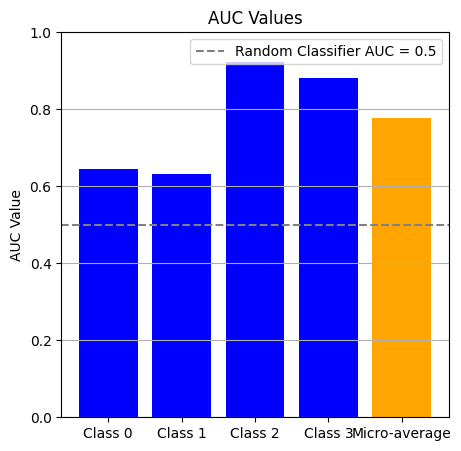

In [140]:

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


n_classes = len(set(y_test))  
y_test_bin = label_binarize(y_test, classes=range(n_classes))  
y_scores = knn.predict_proba(X_test_pca) 


roc_auc = []

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
    roc_auc.append(auc(fpr, tpr))

fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_scores.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)


plt.figure(figsize=(5, 5))
class_names = [f'Class {i}' for i in range(n_classes)] 
class_names.append('Micro-average')  

auc_values = roc_auc + [roc_auc_micro]  

plt.bar(class_names, auc_values, color=['blue'] * n_classes + ['orange'])
plt.ylim(0, 1)  
plt.ylabel('AUC Value')
plt.title('AUC Values')
plt.grid(axis='y')
plt.axhline(y=0.5, color='gray', linestyle='--', label='Random Classifier AUC = 0.5')
plt.legend()
plt.show()


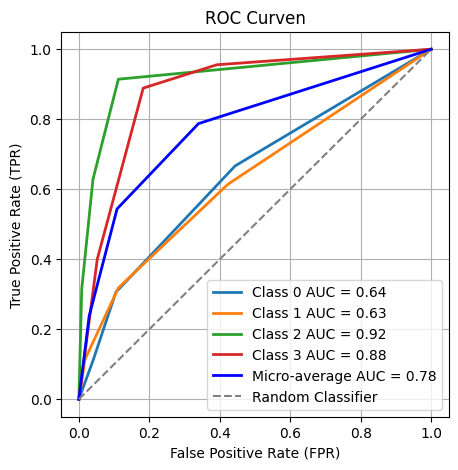

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


plt.figure(figsize=(5, 5))


for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], linewidth=2, label=f"Class {i} AUC = {roc_auc[i]:.2f}")


plt.plot(fpr["micro"], tpr["micro"], color="blue", linewidth=2, label=f"Micro-average AUC = {roc_auc['micro']:.2f}")


plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random Classifier")

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curven")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [142]:
print(f"Micro-average AUC: {roc_auc_micro:.2f}")

Micro-average AUC: 0.78


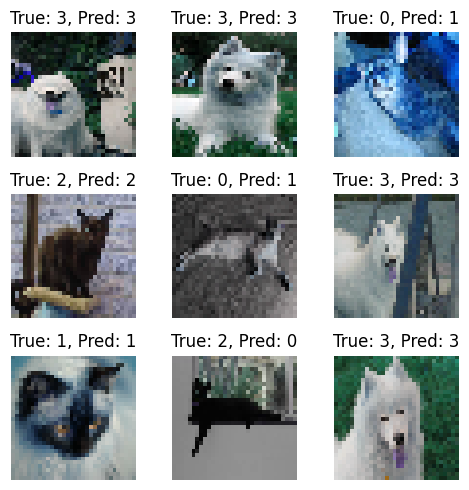

In [143]:
plt.figure(figsize=(5, 5))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[i].reshape(32, 32,3), cmap='gray')
    plt.title(f"True: {y_test[i]}, Pred: {Y_pred[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [144]:
from sklearn.metrics import log_loss
loss_value = log_loss(y_test_bin, y_scores)
print(f"Log Loss: {loss_value:.4f}")

Log Loss: 8.0512
